In [7]:
import os
import hashlib
from base64 import b64encode

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

from tqdm.auto import tqdm
from sklearn.utils import shuffle
import collections

# Задание

> Все считаем на 1000 итерациях


### Дизайн теста бутстреп
1. Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2. Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (2 балла)

3. На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (3 балла за расчет + 2 балла за подроброе объяснение)

4. Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (3 балла)


### Дизайн продолжение

1. Посчитать аналогичный дизайн для:
  - бутстреп + логарифмированная метрика длительности просмотров (4 балла)
  - манна-уитни + метрика длительности просмотров (4 балла)
  - манна-уитни + логарифмированная метрика длительности просмотров (4 балла)
  - t-test + метрика длительности просмотров (4 балла)
  - t-test + логарифмированная метрика длительности просмотров (4 балла)
2. Подробно описать выводы для каждой пары, какие варианты точно не подходят и почему. Объяснить зачем мы логарифмируем метрику и что нам это дает. Аргументированно выбрать 1 пару (метрика + критерий) которым вы будете оценивать АБ тест и какой эффект мы сможем отловить в нашем тесте. (5 баллов)


### A/B тест
1) Представим что у нас прошел тест, используем те же самые данные за 2 недели

2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (2 балла)

3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (1 балла)

4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (2 балла)

5) Посчитайте результат такого теста и сделайте выводы (10 баллов)

## Работа с данными

In [8]:
import requests

# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [9]:
import zipfile

with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [10]:
interactions = pd.read_csv('data_kion/interactions_df.csv')
users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')

In [41]:
interactions.head(5)

# user_id - уникальный идентификатор пользователя
# item_id - уникальный идентификатор контента
# last_watch_dt - последняя дата просмотра юзером определенного контента
# total_dur - суммарная продолжительность просмотра определенного контента юзером (в секундах)
# watched_pct - процент просмотренного контента от общей продолжительности

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [42]:
users.head()

# user_id - уникальный идентификатор пользователя
# kids_flg = 0 - детей нет, если 1 - дети есть
# income - группа, в которую юзер отнесен по доходу
# age - группа, в которую юзер отнесен по возрасту
# sex - пол

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [43]:
users.groupby('age', as_index=False).count()[['age', 'user_id']]

,age,user_id
0,age_18_24,127672
1,age_25_34,233926
2,age_35_44,207043
3,age_45_54,135925
4,age_55_64,75265
5,age_65_inf,46271


In [44]:
items.head(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


Из interactions возьмём данные за 2 последние недели (2021-08-09 по 2021-08-22), как указано в задании

In [11]:
# предобработка данных
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


In [12]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()
print(f'С {min_date} по {max_date}')

С 2021-03-13 по 2021-08-22


In [13]:
# выделим данные за одну (последнюю) неделю
two_week = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]
two_week = two_week.groupby('user_id', as_index=False).agg({'total_dur': sum})

<ipython-input-13-273ae11cad48>:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  two_week = two_week.groupby('user_id', as_index=False).agg({'total_dur': sum})


In [14]:
two_week

,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,33776
3,1000001,52
4,1000003,625
...,...,...
279124,999978,29615
279125,999987,27888
279126,999989,4563
279127,999990,997


## Функции для рассчётов

In [15]:
# Делим на 2 равные группы
def groups_splitter(df, columns, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

In [16]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

## Корректность

In [16]:
correctness = []
values = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций

    new_df = groups_splitter(two_week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    correctness.append(not left_side <= 0 <= right_side)

    test_correctness = collections.Counter(correctness)

print(f'significance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

100%|██████████| 1000/1000 [1:36:00<00:00,  5.76s/it]

significance: 6.6000000000000005%


В сравнении с результатами с семинара (significance = 2%), значение полученное на 2-х неделях при 1000 итерациях для расчётов стало значительно больше (significance = 6,6%) и превысило стандартное значение для ошибки первого рода равное 0.05. Это может быть связано с тем, что наблюдений стало больше, увеличился разброс или что-то не очень хорошо с рапределением значений p-value (мы можем посмотреть на это распределение)

In [17]:
p_values = [get_p_value(dist) for dist in values]

Text(0.5, 1.0, 'Бутстреп распределение p_value')

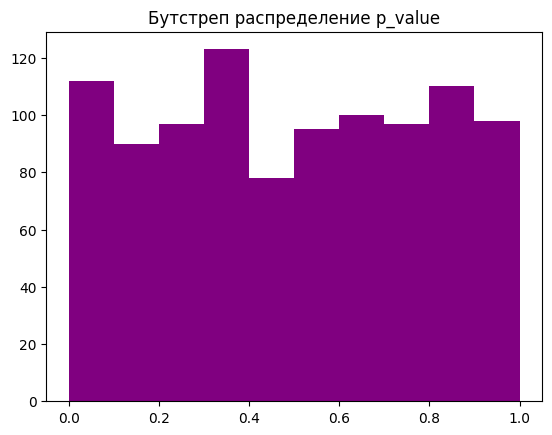

In [18]:
plt.hist(p_values, bins=10, color='purple');
plt.title(f"Бутстреп распределение p_value")

Приведённое выше распределение p-value не похоже на равномерное

## Мощность

На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность

### Эффект в 1%

In [20]:
power = []
values = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций

    new_df = groups_splitter(two_week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * (1+0.01)  # докидаваем эффект в 1%

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

print(f'power: {test_power[1]/(test_power[1] + test_power[0])*100}%')

100%|██████████| 1000/1000 [1:38:17<00:00,  5.90s/it]

power: 11.899999999999999%


### Эффект в 3%

In [22]:
power = []
values = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций

    new_df = groups_splitter(two_week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * (1+0.03)  # докидаваем эффект в 3%

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

print(f'power: {test_power[1]/(test_power[1] + test_power[0])*100}%')

100%|██████████| 1000/1000 [1:37:57<00:00,  5.88s/it]

power: 70.3%


### Эффект в 3%

In [23]:
power = []
values = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций

    new_df = groups_splitter(two_week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * (1+0.05)  # докидаваем эффект в 5%

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

print(f'power: {test_power[1]/(test_power[1] + test_power[0])*100}%')

100%|██████████| 1000/1000 [1:36:01<00:00,  5.76s/it]

power: 98.5%


С увеличением размера эффекта, увеличилась и мощность соответственно. При эффекте в 5% мощьность превысила 95%. Однако в сравнении с динамикой, приведённой на семинаре, в данном случае мощьность растёт значительно менее быстро (в семинаре близкую к 90% мощбность удалось получить на эффекте размером 3%). Из этого можно сказать, что мощьность также чувствительна к количеству данных

## MDE

In [17]:
# Теперь можем написать функцию:
def get_mde(metric_vec, alpha=0.05, beta=0.2):

    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()

    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)

    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)

    return mde*100/metric_mean

MDE рассчитанное на стандартных параметрах, так как некорректно для этой формулы использовать параметры полученные при рассчётах для подхода бутстрап

In [23]:
get_mde(two_week['total_dur'], alpha=0.05, beta=0.2)

1.6664225267460313

MDE рассчитанное на экспериментальных параметрах, так как это было указано в задании

In [24]:
get_mde(two_week['total_dur'], alpha=0.066, beta=0.3)

1.4054412545064572

# Продолжение дизайна. Проверка пар критерий+метрика

- бутстреп + логарифмированная метрика длительности просмотров
- манна-уитни + метрика длительности просмотров 
- манна-уитни + логарифмированная метрика длительности просмотров 
- t-test + метрика длительности просмотров
- t-test + логарифмированная метрика длительности просмотров

In [19]:
two_week.head()

,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,33776
3,1000001,52
4,1000003,625


В некоторых парах в качестве метрики используется логарифмированная метрика длительности просмотров, добавим эту метрику в данные 

In [20]:
two_week['ln_total_dur'] = np.log(two_week['total_dur'])

In [21]:
two_week.head()

,user_id,total_dur,ln_total_dur
0,1,21172,9.960435
1,1000,10744,9.282103
2,1000000,33776,10.427506
3,1000001,52,3.951244
4,1000003,625,6.437752


## Исправленные функциями для ускорения рассчётов

In [22]:
def salt_generator(salt=None):
    return b64encode( os.urandom(8)).decode('ascii')

def get_bootstrap_array(arr, n):
    return np.random.choice(arr, replace=True, size=(n, len(arr)))

def calc_bootstrap_mean(arr, size=1000):
    return np.mean(get_bootstrap_array(arr,size),axis = 1)

def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

# Делим на 2 равные группы
def groups_splitter(df, columns, user_salt=None):
    user_salt = user_salt if user_salt else salt_generator()
    df['hash'] = ((df['user_id'].astype(str)) + '#' + user_salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))
    return df[columns].drop_duplicates()

## Бутстреп + логарифмированная метрика длительности просмотров

### Распределение p-value

In [57]:
correctness = []
values = []

for i in tqdm(range(1000),leave=True): # в дз используем 1000 итераций

    new_df = groups_splitter(two_week.copy(), columns=['user_id', 'ln_total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['ln_total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['ln_total_dur']

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    correctness.append(not left_side <= 0 <= right_side)

    test_correctness = collections.Counter(correctness)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [58]:
p_values = [get_p_value(dist) for dist in values]

Text(0.5, 1.0, 'Pаспределение p_value(Бутстрап+ln_total_dur)')

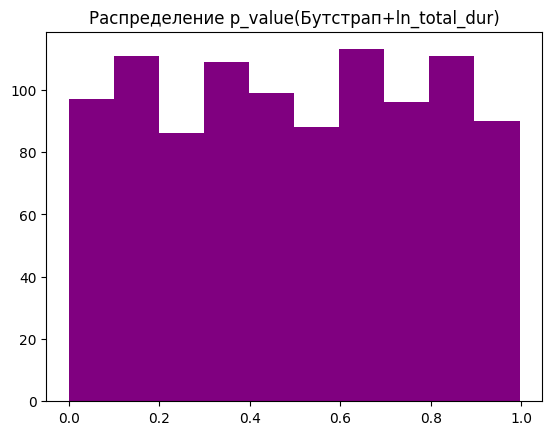

In [60]:
plt.hist(p_values, bins=10, color='purple');
plt.title(f"Pаспределение p_value(Бутстрап+ln_total_dur)")

In [61]:
stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.9563931502431962 - p_values равномерное распределение


### Корректность

In [62]:
significance = test_correctness[1]/(test_correctness[1] + test_correctness[0])
print(f'Correctness: {(1- significance)*100}%, \nSignificance: {significance*100}%')

Correctness: 94.89999999999999%, 
Significance: 5.1%


Significance превышает 5%, поэтому скорее всего эта пара критерий+метрика не будет использоваться, однако проверим ещё мощность для этой пары. Посчитаем её для эффекта в 3%

### Мощность

In [21]:
power = []
values = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций

    new_df = groups_splitter(two_week.copy(), columns=['user_id', 'ln_total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['ln_total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['ln_total_dur'] + np.log(1+0.03)  # докидаваем эффект в 3%

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
print(f'Power: {test_power[1]/(test_power[1] + test_power[0])*100}%')

Power: 22.0%


Мощность у пары тоже довольно низкая

## Манна-уитни + метрика длительности просмотров 

### Распределение p-value

In [51]:
pvalues = []

for i in tqdm(range(1000)):  # 1000

  two_week_df = groups_splitter(two_week, columns=['user_id', 'total_dur', 'group'])

  u, p = mannwhitneyu(
        two_week_df[two_week_df['group'] == 'A']['total_dur'].values,
        two_week_df[two_week_df['group'] == 'B']['total_dur'].values
    )

  pvalues.append(p)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Pаспределение p_value(Манна-уитни+total_dur)')

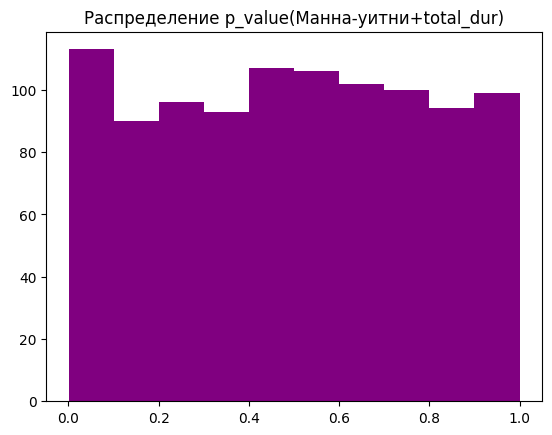

In [52]:
plt.hist(pvalues, bins=10, color='purple');
plt.title(f"Pаспределение p_value(Манна-уитни+total_dur)")

In [53]:
stat, pvalue = scipy.stats.kstest(pvalues, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if pvalue < 0.05:
    print(f'p_value = {pvalue} - p_values неравномерное распределение')
else:
    print(f'p_value = {pvalue} - p_values равномерное распределение')

p_value = 0.8036462108041096 - p_values равномерное распределение


### Корректность

In [54]:
significance = np.mean(np.array(pvalues) < 0.05)
print(f'Correctness: {(1- significance)*100:0.2f}%, \nSignificance: {significance*100:0.2f}%')

Correctness: 95.50%, 
Significance: 4.50%


Significance не превышает 5%, поэтому посчитаем для данной пары мощность с эффектом в 3%

### Мощность

In [59]:
pvalues_ab = []

for i in tqdm(range(1000),leave=True): # в дз используем 1000 итераций

    two_week_df = groups_splitter(two_week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = two_week_df[(two_week_df['group'] == 'A')]['total_dur']
    vec_b = two_week_df[(two_week_df['group'] == 'B')]['total_dur']* (1+0.03)

    u, p = mannwhitneyu(vec_a.values,
                      vec_b.values)
    pvalues_ab.append(p)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [60]:
power = np.mean(np.array(pvalues_ab) < 0.05)
print(f'Ppower: {power*100}%')

Ppower: 98.3%


Довольно высокая мощность

## Манна-уитни + логарифмированная метрика длительности просмотров 

### Распределение p-value

In [26]:
pvalues = []

for i in tqdm(range(1000)):  # 1000

  two_week_df = groups_splitter(two_week, columns=['user_id', 'ln_total_dur', 'group'])

  u, p = mannwhitneyu(
        two_week_df[two_week_df['group'] == 'A']['ln_total_dur'].values,
        two_week_df[two_week_df['group'] == 'B']['ln_total_dur'].values
    )

  pvalues.append(p)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Pаспределение p_value(Манна-уитни+ln_total_dur)')

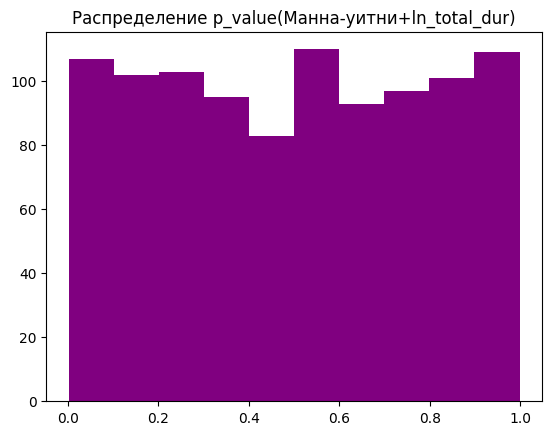

In [27]:
plt.hist(pvalues, bins=10, color='purple');
plt.title(f"Pаспределение p_value(Манна-уитни+ln_total_dur)")

In [28]:
stat, pvalue = scipy.stats.kstest(pvalues, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if pvalue < 0.05:
    print(f'p_value = {pvalue} - p_values неравномерное распределение')
else:
    print(f'p_value = {pvalue} - p_values равномерное распределение')

p_value = 0.443284685545705 - p_values равномерное распределение


### Корректность

In [29]:
significance = np.mean(np.array(pvalues) < 0.05)
print(f'Correctness: {(1- significance)*100:0.2f}%, \nSignificance: {significance*100:0.2f}%')

Correctness: 94.70%, 
Significance: 5.30%


Significance превышает 5%, поэтому скорее всего эта пара критерий+метрика не будет использоваться, однако проверим ещё мощность для этой пары. Посчитаем её для эффекта в 3%

In [23]:
pvalues_ab = []

for i in tqdm(range(1000),leave=True): # в дз используем 1000 итераций

    two_week_df = groups_splitter(two_week.copy(), columns=['user_id', 'ln_total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = two_week_df[(two_week_df['group'] == 'A')]['ln_total_dur']
    vec_b = two_week_df[(two_week_df['group'] == 'B')]['ln_total_dur']+ np.log(1+0.03)

    u, p = mannwhitneyu(vec_a.values,
                      vec_b.values)
    pvalues_ab.append(p)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
power = np.mean(np.array(pvalues_ab) < 0.05)
print(f'Ppower: {power*100:0.2f}%')

Ppower: 97.10%


Мощность довольно высокая, но вероятность ошибки первого рода важнее для выбора

## t-test + метрика длительности просмотров

### Распределение p-value

In [26]:
pvalues = []

for i in tqdm(range(1000)):  # 1000

  two_week_df = groups_splitter(two_week, columns=['user_id', 'total_dur', 'group'])

  p = stats.ttest_ind(
        two_week_df[two_week_df['group'] == 'A']['total_dur'].values,
        two_week_df[two_week_df['group'] == 'B']['total_dur'].values
    ).pvalue
  pvalues.append(p)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Pаспределение p_value(T-тест+total_dur)')

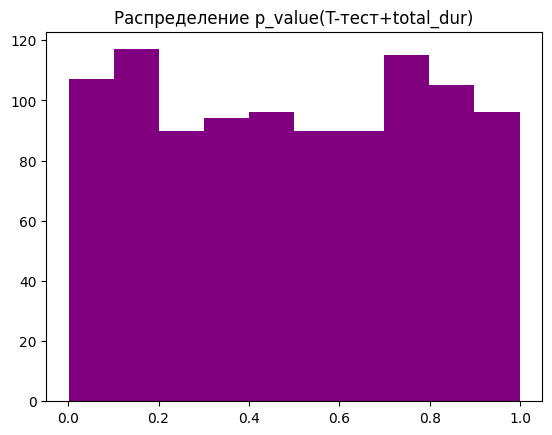

In [27]:
plt.hist(pvalues, bins=10, color='purple');
plt.title(f"Pаспределение p_value(T-тест+total_dur)")

In [35]:
stat, pvalue = scipy.stats.kstest(pvalues, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if pvalue < 0.05:
    print(f'p_value = {pvalue} - p_values неравномерное распределение')
else:
    print(f'p_value = {pvalue} - p_values равномерное распределение')

p_value = 0.3819925240901352 - p_values равномерное распределение


### Корректность

In [40]:
significance = np.mean(np.array(pvalues) < 0.05)
print(f'Correctness: {(1- significance)*100:0.2f}%, \nSignificance: {significance*100:0.2f}%')

Correctness: 94.20%, 
Significance: 5.80%


Significance превышает 5%, поэтому скорее всего эта пара критерий+метрика не будет использоваться, однако проверим ещё мощность для этой пары. Посчитаем её для эффекта в 3%

In [33]:
pvalues_ab = []

for i in tqdm(range(1000),leave=True): # в дз используем 1000 итераций

    two_week_df = groups_splitter(two_week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = two_week_df[(two_week_df['group'] == 'A')]['total_dur']
    vec_b = two_week_df[(two_week_df['group'] == 'B')]['total_dur']* (1+0.03)

    p = stats.ttest_ind(vec_a.values,
                      vec_b.values).pvalue
    pvalues_ab.append(p)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [38]:
power = np.mean(np.array(pvalues_ab) < 0.05)
print(f'Ppower: {power*100}%')

Ppower: 68.5%


Мощность тоже не очень высокая

## t-test + логарифмированная метрика длительности просмотров

### Распределение p-value

In [44]:
pvalues = []

for i in tqdm(range(1000)):  # 1000

  two_week_df = groups_splitter(two_week, columns=['user_id', 'ln_total_dur', 'group'])

  p = stats.ttest_ind(
        two_week_df[two_week_df['group'] == 'A']['ln_total_dur'].values,
        two_week_df[two_week_df['group'] == 'B']['ln_total_dur'].values
    ).pvalue
  pvalues.append(p)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Pаспределение p_value(T-тест+ln_total_dur)')

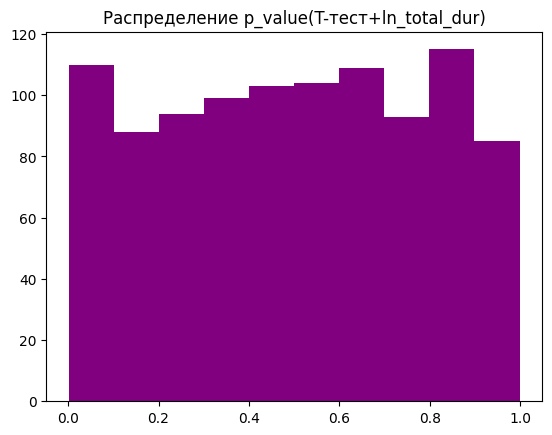

In [45]:
plt.hist(pvalues, bins=10, color='purple');
plt.title(f"Pаспределение p_value(T-тест+ln_total_dur)")

In [46]:
stat, pvalue = scipy.stats.kstest(pvalues, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if pvalue < 0.05:
    print(f'p_value = {pvalue} - p_values неравномерное распределение')
else:
    print(f'p_value = {pvalue} - p_values равномерное распределение')

p_value = 0.8227328966527417 - p_values равномерное распределение


### Корректность

In [48]:
significance = np.mean(np.array(pvalues) < 0.05)
print(f'Correctness: {(1- significance)*100:0.2f}%, \nSignificance: {significance*100:0.2f}%')

Correctness: 95.60%, 
Significance: 4.40%


### Мощность

In [25]:
pvalues_ab = []

for i in tqdm(range(1000),leave=True): # в дз используем 1000 итераций

    two_week_df = groups_splitter(two_week.copy(), columns=['user_id', 'ln_total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = two_week_df[(two_week_df['group'] == 'A')]['ln_total_dur']
    vec_b = two_week_df[(two_week_df['group'] == 'B')]['ln_total_dur']+ np.log(1+0.03)

    p = stats.ttest_ind(vec_a.values,
                      vec_b.values).pvalue
    pvalues_ab.append(p)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
power = np.mean(np.array(pvalues_ab) < 0.05)
print(f'Power: {power*100}%')

Power: 87.8%


## Выводы по проверкам


Все пары критерий+метрика показали равномерное распределение p-value, поэтому оценка проходила по рассчитаным значениям корректности и мощности

### **бутстреп + логарифмированная метрика длительности просмотров**
- Correctness: 94.9%,
- Significance: 5.1%
- Power: 22.0%
### **манна-уитни + метрика длительности просмотров**
- Correctness: 95.5%
- Significance: 4.5%
- Power: 98.3%
### **манна-уитни + логарифмированная метрика длительности просмотров**
- Correctness: 94.7%
- Significance: 5.3%
- Power: 97.1%
### **t-test + метрика длительности просмотров**
- Correctness: 94.2%
- Significance: 5.8%
- Power: 68.5%
### **t-test + логарифмированная метрика длительности просмотров**
- Correctness: 95.6%
- Significance: 4.4%
- Power: 87.8%


По итогам измерений пары t-test + метрика длительности просмотров и манна-уитни + логарифмированная метрика длительности просмотров показали значение Significance большее, чем 5%, вследствие чего были отклонены из-за слишком большой вероятности ошибки первого рода. Пара бутстреп + логарифмированная метрика длительности просмотров помимо значения Significance большего, чем 5%, показала весьма низкую мощность и также была отклонена. Из двух оставшихся пар - более хорошие показатели были у пары манна-уитни + метрика длительности просмотров

# A/B тест

Лучше всего в условиях эксперимента себя показали 2 пары критерий+метрика: 
- манна-уитни + метрика длительности просмотров *(более сильные значения)*
- t-test + логарифмированная метрика длительности просмотров *(менее сильные значения)*

Однако условия, описанные в задании А/В теста исключают возможность использовать пару  манна-уитни + метрика длительности просмотров (так как проверка показала, что в данных появляется очень много одинаковых(занулённых) значений, поэтому ранговый критений манна-уитни скорее всего не покажет себя хорошо), поэтому применим пару t-test + логарифмированная метрика длительности просмотров

**Пояснение применения логарифмированной метрики в выбранном случае:** Так как для A/B теста было решено использовать t-test, то данные, распределение которых совсем не похоже на нормальное следует преобразовать, чтобы критерий сработал нормально. Эксперименты из семинара показали, что логарифмирование данных позволило привести их к более похожему на нормальное распределению, поэтому для теста в качестве метрики выбрана именно логарифмированная метрика длительности просмотров

## Представим что у нас прошел тест, используем те же самые данные за 2 недели

In [30]:
two_week

,user_id,total_dur,ln_total_dur
0,1,21172,9.960435
1,1000,10744,9.282103
2,1000000,33776,10.427506
3,1000001,52,3.951244
4,1000003,625,6.437752
...,...,...,...
279124,999978,29615,10.296036
279125,999987,27888,10.235952
279126,999989,4563,8.425736
279127,999990,997,6.904751


## Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте

Так как для выбранной пары критерий+метрика используется логарифмированная метрика, то заменим значения на 1, чтобы при логарифмировании они дали 0

In [31]:
two_week.loc[two_week['total_dur'] < 500, 'total_dur'] = 1
two_week['ln_total_dur'] = np.log(two_week['total_dur'])
two_week.head(5)

,user_id,total_dur,ln_total_dur
0,1,21172,9.960435
1,1000,10744,9.282103
2,1000000,33776,10.427506
3,1000001,1,0.000000
4,1000003,625,6.437752


## Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805'

In [32]:
new_data = groups_splitter(two_week.copy(), 
                           columns=['user_id', 'total_dur', 'ln_total_dur','group'], 
                           user_salt='kiontestmodel20210805').drop_duplicates()

In [33]:
new_data.head(5)

,user_id,total_dur,ln_total_dur,group
0,1,21172,9.960435,B
1,1000,10744,9.282103,B
2,1000000,33776,10.427506,B
3,1000001,1,0.000000,B
4,1000003,625,6.437752,A


In [34]:
new_data.shape

(279129, 4)

In [35]:
new_data[new_data['ln_total_dur']==0].shape

(53089, 4)

## Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением.

Так как для выбранной пары критерий+метрика используется логарифмированная метрика, то эффект соответственно добавим к ней

In [36]:
b_group = new_data[new_data['group'] == 'B']
b_group = b_group.sort_values('ln_total_dur', ascending=False)
b_group.loc[b_group.index[:int(len(b_group) * 0.1)], 'ln_total_dur'] += np.log(1.025)
# b_group.loc[b_group.index[:int(len(b_group) * 0.1)], 'total_dur'] *= 1.025
new_data.update(b_group)

In [37]:
new_data

,user_id,total_dur,ln_total_dur,group
0,1,21172,9.960435,B
1,1000,10744,9.282103,B
2,1000000,33776,10.427506,B
3,1000001,1,0.000000,B
4,1000003,625,6.437752,A
...,...,...,...,...
279124,999978,29615,10.296036,A
279125,999987,27888,10.235952,A
279126,999989,4563,8.425736,B
279127,999990,997,6.904751,B


## Посчитайте результат такого теста и сделайте выводы

In [38]:
p = stats.ttest_ind(
        new_data[new_data['group'] == 'A']['ln_total_dur'].values,
        new_data[new_data['group'] == 'B']['ln_total_dur'].values
    ).pvalue

In [39]:
print(f'p-values: {p:0.2f}')

p-values: 0.12


Полученное значение p-values > 0.05 (p-values =  0.12), это не позволяет отклонить нулевую гепотезу о том, что целевые группы А и В значительно отличаются (полученный эффект не даёт возможности сказать о статистически значимых проявлениях эффекта)